In [241]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
from nemo import evaluate_nemo
import util
from topology import get_lognorm_hist
import topology
from util import evaluate

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Topology Setup

In [242]:
seed = 10
device_number = 1000 + 1
avg = 50
c_capacity = 50
max_resources = device_number * avg - c_capacity

X_dim_range = [0, 100]
Y_dim_range = [-50, 50]
centers = 40

H, bins = get_lognorm_hist()
coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, seed=seed, with_latency=True)
coord_dict = {"sim(1000)": coords_df[["x", "y"]]}

df_dict_topologies = topology.create_topologies_from_dict(coord_dict, H, max_resources, c_capacity,
                                                          weights=(1, 1), dist="lognorm", with_clustering=True,
                                                          kmin=10, kmax=30, kseed=10)

Creating df for sim(1000)
Optimal k is 29
Done


In [243]:
coords_df

,x,y,latency
0,6.299799,7.016776,0.000000
1,65.979370,15.023880,60.214326
2,24.266213,40.309398,37.831082
3,32.539280,27.839824,33.497906
4,-1.100279,-0.750388,10.727999
...,...,...,...
996,5.437920,35.475608,28.471881
997,18.635320,22.520716,19.812553
998,15.206886,27.645818,22.469837
999,65.864324,46.312725,71.358982


In [244]:
coord_list = []
coord_list.append(coords_df)

for i in range(0, 10):
    coords_df = topology.coords_sim(1000, centers, X_dim_range, Y_dim_range, with_latency=True)
    coord_list.append(coords_df)
    
len(coord_list)

11

In [245]:
t_label = "sim(1000)"
prim_df, c_coords, base_col, slot_columns, centroids, opt_k, sil = df_dict_topologies[t_label]
coords = prim_df[["x", "y"]].to_numpy()

eval_matrix = {}
prim_df

,x,y,latency,type,base,weight,capacity_100,capacity_90,capacity_80,capacity_70,capacity_60,capacity_50,capacity_40,capacity_30,capacity_20,capacity_10,capacity_5,capacity_1,cluster
0,6.299799,7.016776,0.000000,coordinator,9223372036854775807,0,50,50,50,50,50,50,50,50,50,50,50,50,-1
1,65.979370,15.023880,60.214326,worker,9223372036854775807,1,50,50,56,61,55,52,47,66,31,27,26,119,22
2,24.266213,40.309398,37.831082,worker,9223372036854775807,1,50,51,46,44,44,62,73,100,56,17,24,21,19
3,32.539280,27.839824,33.497906,worker,9223372036854775807,1,50,48,46,49,50,41,37,33,29,36,240,35,17
4,-1.100279,-0.750388,10.727999,worker,9223372036854775807,1,50,48,51,43,62,55,59,65,27,23,29,63,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
996,5.437920,35.475608,28.471881,worker,9223372036854775807,1,50,48,53,45,52,38,74,39,99,25,193,0,1
997,18.635320,22.520716,19.812553,worker,9223372036854775807,1,50,48,50,50,50,40,34,38,34,23,11,11,1
998,15.206886,27.645818,22.469837,worker,9223372036854775807,1,50,48,49,45,60,40,45,39,51,50,13,129,1
999,65.864324,46.312725,71.358982,worker,9223372036854775807,1,50,52,47,45,40,52,35,40,35,17,26,98,15


In [246]:
print("Required:", prim_df["weight"].sum(), "Available:", prim_df["capacity_100"].sum())
colors, light_colors, palette = util.get_color_list(opt_k)
palette

Required: 1000 Available: 50050


[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)]

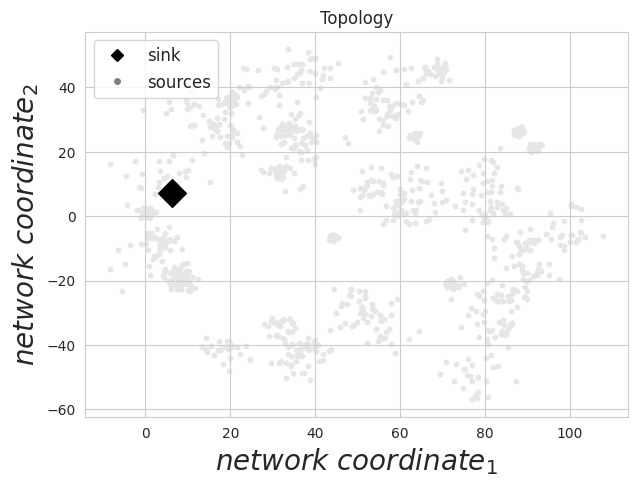

In [247]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))
ax1 = util.plot_topology(ax1, prim_df, scale_fac=0.1)

X_dim = ax1.get_xlim()
Y_dim = ax1.get_ylim()

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs.svg", bbox_inches="tight")

plt.show()

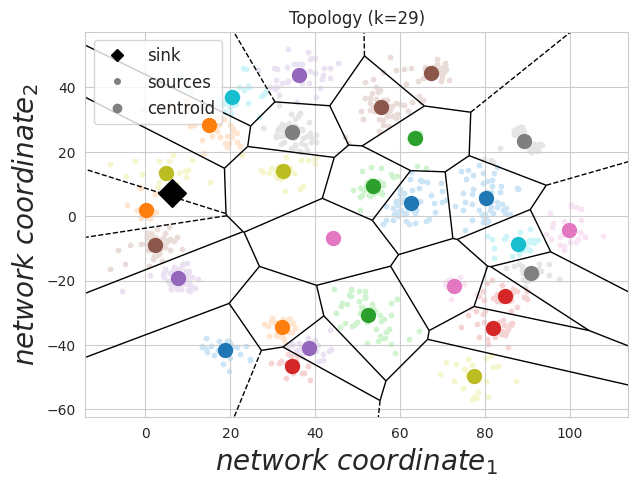

In [248]:
fig, (ax1) = plt.subplots(1, 1, figsize=(7, 5))

ax1 = util.plot_topology(ax1, prim_df, colors=colors, title='Topology (k=' + str(opt_k) + ")", scale_fac=0.1,
                         plot_voronoi=True, plot_centroid=True)

ax1.set_xlim(X_dim)
ax1.set_ylim(Y_dim)

# plt.savefig("plots/sim_1000/sim_" + str(device_number - 1) + "_ncs_grouped.svg", bbox_inches="tight")

plt.show()

### Identify parameters

In [214]:
skip = False

# fixed params
max_levels = 50
slot_col = "capacity_100"
weight_col = "weight"

# dynamic params
num_points = 9
start = 0.1
end = 0.9
hyperparam_values_1 = np.linspace(start, end, num_points)
hyperparam_values_2 = np.linspace(start, end, num_points)
X, Y = np.meshgrid(hyperparam_values_1, hyperparam_values_2)

# Initialize an array to store performance values
perc_lat_values = np.zeros_like(X)
mean_lat_values = np.zeros_like(X)

for i in range(num_points):
    for j in range(num_points):
        if skip:
            continue
            
        eval_dict, df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col, merge_factor=X[i, j],
                                                                  step_size=Y[i, j], max_levels=max_levels,
                                                                  with_eval=True)
        sv = eval_dict[slot_col]["latency_distribution"].sort_values()
        perc_lat = round(sv.quantile(0.9), 2)
        mean_lat = round(sv.mean(), 2)
        print(perc_lat, mean_lat)

        perc_lat_values[i, j] = perc_lat
        mean_lat_values[i, j] = mean_lat

Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 29 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  32
Evaluating for capacity_100
86.59 53.91
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.2
Level 0 CH number:  1000
--------Balancing load for 29 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  32
Evaluating for capacity_100
86.59 53.91
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.30000000000000004
Level 0 CH number:  1000
--------Balancing load for 29 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  32
Evaluating for capacity_100
86.59 53.91
Starting nemo for: c=capacity_100, w=weight, l=50, step_size=0.1, merge_factor=0.4
Level 0 CH number:  1000
--------Balancing load for 

merge factor and step size for minimum latency (90P): (X=0.1, Y=0.4) 86.51
merge factor and step size for minimum latency (mean): (X=0.1, Y=0.30000000000000004) 53.42


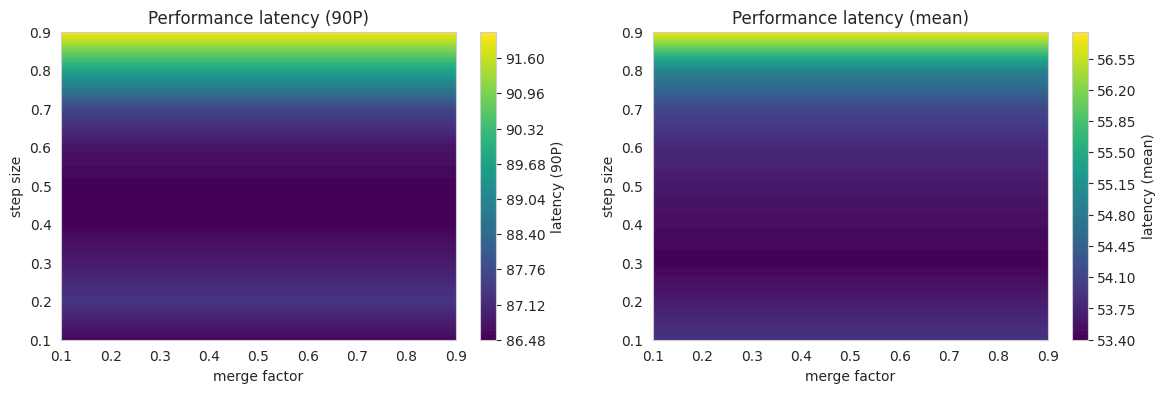

In [215]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

for i, values in enumerate([perc_lat_values, mean_lat_values]):
    if i == 0:
        label = "latency (90P)"
    elif i == 1:
        label = "latency (mean)"
    else:
        label = "undefined"

    # Find the indices of the minimum Z value
    min_index = np.unravel_index(np.argmin(values), values.shape)
    # Use the indices to get the corresponding X and Y values
    min_X = X[min_index]
    min_Y = Y[min_index]
    print(f"merge factor and step size for minimum {label}: (X={min_X}, Y={min_Y})", values[min_index])

    # Create a contour plot
    ax = axs[i]
    contour = ax.contourf(X, Y, values, levels=80, cmap='viridis')

    # Create a colorbar and set the label
    colorbar = plt.colorbar(contour)
    colorbar.set_label(label)

    ax.set_title(f"Performance {label}")
    ax.set_xlabel('merge factor')
    ax.set_ylabel('step size')

plt.show()

In [249]:
param_dict = {
    "weight_1": {"merge_factor": 0.4, "step_size": 0.2},
    "weight_2": {"merge_factor": 0.4, "step_size": 0.2},
    "weight": {"merge_factor": 0.1, "step_size": 0.3}
}

### Changing Topology

In [271]:
# for the plots and vanilla NEMO
eval_name = "nemo_dc"
slot_col = "capacity_100"
weight_col = "weight"

df_dict, opt_dict, limits_dict = evaluate_nemo(prim_df, [slot_col], weight_col,
                                                                       merge_factor=param_dict[weight_col][
                                                                           "merge_factor"],
                                                                       step_size=param_dict[weight_col]["step_size"],
                                                                       with_eval=False)
df = df_dict[slot_col]

Starting nemo for: c=capacity_100, w=weight, l=20, step_size=0.3, merge_factor=0.1
Level 0 CH number:  1000
--------Balancing load for 29 clusters to 0
Clusters processed: 0
Clusters processed: 10
Clusters processed: 20
Level 1 CH number:  34


In [272]:
df = df.drop(columns=["x", "y"])
df

,oindex,type,cluster,total_weight,used_weight,total_capacity,free_capacity,level,parent
0,0,coordinator,-1,<NA>,<NA>,50,19,2,<NA>
1,1,worker,22,1,1,50,46,1,0
2,2,worker,19,1,1,50,50,0,927
3,3,worker,17,1,1,50,50,0,395
4,4,worker,11,1,1,50,50,0,718
...,...,...,...,...,...,...,...,...,...
996,996,worker,1,1,1,50,50,0,647
997,997,worker,1,1,1,50,50,0,647
998,998,worker,1,1,1,50,50,0,647
999,999,worker,15,1,1,50,50,0,870


In [273]:
evaluations = []
for coords_df in coord_list:
    coords = coords_df[["x", "y"]].to_numpy()
    edf = evaluate(df, coords)
    evaluations.append(edf)

In [274]:
evaluations[0]

,latency_distribution,received_packets
0,0.000000,31.0
1,60.214326,4.0
2,37.999076,0.0
3,33.537098,0.0
4,10.789639,0.0
...,...,...
996,32.260923,0.0
997,23.402141,0.0
998,22.471732,0.0
999,71.688615,0.0


## Evaluation

#### Latency

In [275]:
eval_colors = {
    "dt": colors[0],
    "leach": colors[1],
    "mst": colors[2],
    "chain": colors[3],
    "nemo": colors[4],
    "nemo_base": colors[4],
    "nemo_dc_base": colors[4],
    "NEMO_base": colors[4],
    "nemo_rc": colors[5],
    "nemo_rc_base": colors[5],
    "nemo (rdm groups)_base": colors[5],
    "nemo_dc": colors[6],
    "NEMO+redistribution": colors[6],
    "nemo_pen": colors[7],
    "nemo_pen_base": colors[8],
    "nemo_dc_weight_2": colors[9],
    "nemo_dc_weight": colors[10]
}

renaming_dict = {
    "nemo_dc": "nemo (w=1,",
    "nemo_dc_weight_2": "nemo (w=2,",
    "nemo_dc_weight": "nemo (w=ln[1, 50],",
}


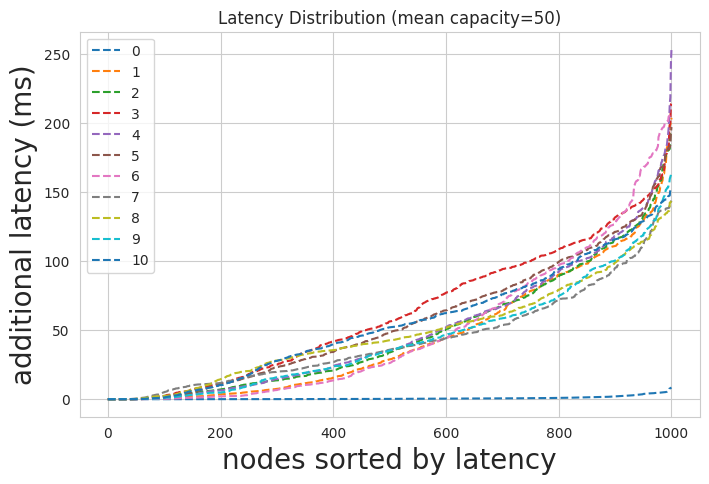

Means:  {'0': 0.72, '1': 44.57, '2': 47.96, '3': 62.87, '4': 49.67, '5': 56.25, '6': 49.03, '7': 42.98, '8': 48.01, '9': 43.34, '10': 54.84}
Quantiles:  {'0': 2.05, '1': 111.01, '2': 116.11, '3': 131.75, '4': 118.27, '5': 121.23, '6': 127.45, '7': 95.07, '8': 98.91, '9': 100.54, '10': 115.88}
AUC:  {'0': 0.0, '1': 23075.23, '2': 23512.51, '3': 26230.05, '4': 24539.26, '5': 24806.59, '6': 27141.26, '7': 19212.08, '8': 20026.97, '9': 20709.57, '10': 23021.26}


In [326]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5), sharey="all")
quant_dict = {}
mean_dict = {}
auc_dict = {}

error_val = 0.8
start_index = int(prim_df.shape[0] * error_val)
init_placement_latency = (evaluations[0]["latency_distribution"] - coord_list[0]["latency"]).sort_values().to_numpy()

for i, df in enumerate(evaluations):
    l = str(i)
    df = df.copy()
    df["latency_distribution"] = df["latency_distribution"] - coord_list[i]["latency"]
    sv = df["latency_distribution"].sort_values()
    
    # calculate area under the curves for error
    # Extract the sublist within the calculated index range
    sublist1 = init_placement_latency[start_index:]
    sublist2 = sv.to_numpy()[start_index:]
    # Calculate the area under the curve using numpy.trapz
    auc = np.trapz(np.abs(sublist1 - sublist2))
    
    auc_dict[l] = round(auc, 2)
    quant_dict[l] = round(sv.quantile(0.9), 2)
    mean_dict[l] = round(sv.mean(), 2)
    sv.plot(ax=ax1, use_index=False, label=l, linestyle="--")

ax1.set_xlabel('nodes sorted by latency')
ax1.set_ylabel('additional latency (ms)')

ax1.legend(loc="upper left", prop={'size': 10})
# Display a figure.
# plt.ylim([0, 100])

ax1.yaxis.label.set_size(20)
ax1.xaxis.label.set_size(20)

# plt.savefig("plots/sim_1000/eval_latency.svg")

ax1.set_title('Latency Distribution (mean capacity=' + str(avg) + ")")
plt.show()
print("Means: ", mean_dict)
print("Quantiles: ", quant_dict)
print("AUC: ", auc_dict)

In [328]:
# TODO: add support to re-optimize a batch of nodes